<a href="https://colab.research.google.com/github/gitesh216/ml-comment-sentiment/blob/main/comment_sentiment_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

In [2]:
# Load Dataset (assuming your data is already in a CSV or DataFrame)
df = pd.read_csv("comment_eda_output.csv")

In [3]:
df.head(5)

,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0


In [12]:
# Define features and target

X = df[['clean_comment', 'word_count', 'num_stop_words', 'num_chars', 'num_punctuation_chars']]
y = df['category']   # -1 = negative, 0 = neutral, 1 = positive

# Replace NaN values in 'clean_comment' with empty strings
X['clean_comment'] = X['clean_comment'].fillna('')

/tmp/ipython-input-1445957822.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['clean_comment'] = X['clean_comment'].fillna('')


In [13]:
# Map categories from [-1, 0, 1] → [0, 1, 2]
label_mapping = {-1: 0, 0: 1, 1: 2}
df['category'] = df['category'].map(label_mapping)

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Create preprocessing pipeline
text_transformer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

numeric_features = ['word_count', 'num_stop_words', 'num_chars', 'num_punctuation_chars']
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'clean_comment'),
        ('num', numeric_transformer, numeric_features)
    ])

In [16]:
# Create full pipeline with XGBoost
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        learning_rate=0.1,
        max_depth=6,
        n_estimators=200,
        random_state=42
    ))
])


In [17]:
# Train model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'clean_comment'),
                                                 ('num', StandardScaler(),
                                                  ['word_count',
                                                   'num_stop_words',
                                                   'num_chars',
                                                   'num_punctuation_chars'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None, num_class=3, ...))])

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.50      0.63      1656
           1       0.76      0.93      0.84      2584
           2       0.79      0.82      0.81      3166

    accuracy                           0.79      7406
   macro avg       0.80      0.75      0.76      7406
weighted avg       0.79      0.79      0.78      7406



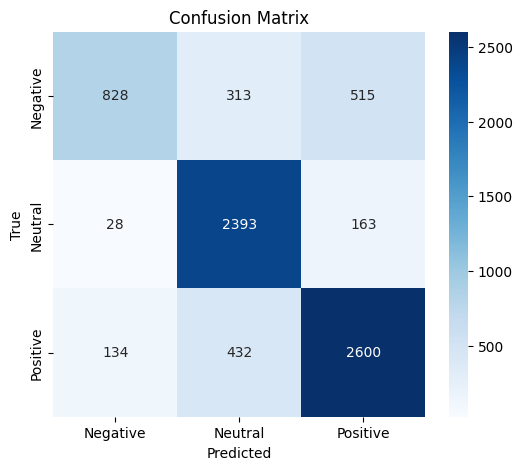

In [18]:
# Evaluate
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()